#  Early RPC cells Subclutering

This Python notebook performs an analysis of the cell types and their marker genes on provided 10X dataset. Specifically, we'll focus on subclustering Early RPC cells. The data set contains ~107,000 cells of which approximately a half come from E14, E18, and P2. About ~15000 of these cells are labeled as Early RPC cells.

# 0. Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns



In [2]:
#sc.logging.print_versions()

In [3]:
sc.settings.verbosity = 3            
sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rcParams['figure.figsize']=(6,6) #rescale figures

# 1. Reading in the data

The count matrix is provided in .mtx format and can be downloaded here: [10x_mouse_retina_development.mtx](https://www.dropbox.com/s/6d76z4grcnaxgcg/10x_mouse_retina_development.mtx?dl=0)

- matrix.mtx - The count matrix containing raw counts for barcodes. Rows correspond to cells and columns to genes
- genes.tsv - contains the ensembl IDs labelling the genes in each column of the counts matrix
- barcodes.tsv - contains the cell barcodes labelling the cells in each row of the counts matrix
- 10x_Mouse_retina_pData_umap2_CellType_annot_w_horiz.csv - Cellular Phenotype Data


Finally, the `Macosko_cell_cycle_genes.txt` contains a list of marker genes for different cell cycle phases. We'd use this file in the <a href=#CC>Cell cycle scoring</a> section to compute cell cycle scores, but will not particularly regress out cell cycle effects.


In [4]:
# Set up data loading
results_file = 'swrite10x/retsmart.h5ad'  
adata = sc.read_10x_mtx(
    'sdata10x',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
cells = pd.read_csv('sdata10x/10x_Mouse_retina_pData_umap2_CellType_annot_w_horiz.csv')
adata.obs['CellType']=cells['umap2_CellType'].values
adata.obs['oCellType']=cells['old_CellType_annot'].values

adata.obs['Age']=cells['age'].values
adata.obs['Plate']=cells['sample'].values

adata=adata[(adata.obs['Age']=='E14') | (adata.obs['Age']=='E18') | (adata.obs['Age']=='P2'),:]
adata=adata[adata.obs.CellType.str.startswith('Early'), :]


... reading from cache file cache\sdata10x-matrix.h5ad


Checking the total size of the data set

In [5]:
adata.shape

(15224, 27998)

We have 60366 cells and 27998 genes in the dataset.

<a id="Preprocessing"></a>

# 2 Pre-processing and visualization

<a id="QC"></a>

## 2.1 Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.


In [6]:
# Quality control - calculate QC covariates
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
adata.var['hb'] = adata.var_names.str.startswith(("Hba","Hbb","Hbq"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

# adata.obs['total_counts'] = adata.X.sum(1)
adata.obs['total_counts_log'] = np.log10(adata.obs['total_counts'])


Trying to set attribute `.var` of view, copying.


In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

In [7]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 500)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 10000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['pct_counts_mt'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))





Total number of cells: 15224
Number of cells after min count filter: 15224
filtered out 30 cells that have more than 10000 counts
Number of cells after max count filter: 15194
Number of cells after MT filter: 15174


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 15174


In [8]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 13149 genes that are detected in less than 5 cells
Number of genes after cell filter: 14849


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 5 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

<a id="Normalization"></a>

## 2.2 Normalization

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. 


In [9]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)
sc.pp.log1p(adata)




normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Before normalizing the data, we filter out ribosormal and mitochondrial genes so that downstream analysis to find marker genes which are based on the raw data does not include these genes. 

In [10]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
bdata=adata.copy()
remove= np.add(bdata.var['ribo'], adata.var['mt'])

keep=np.invert(remove)
bdata=bdata[:,keep]
adata.raw = bdata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

## 2.4 Highly Variable Genes

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software CellRanger. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.


In [11]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


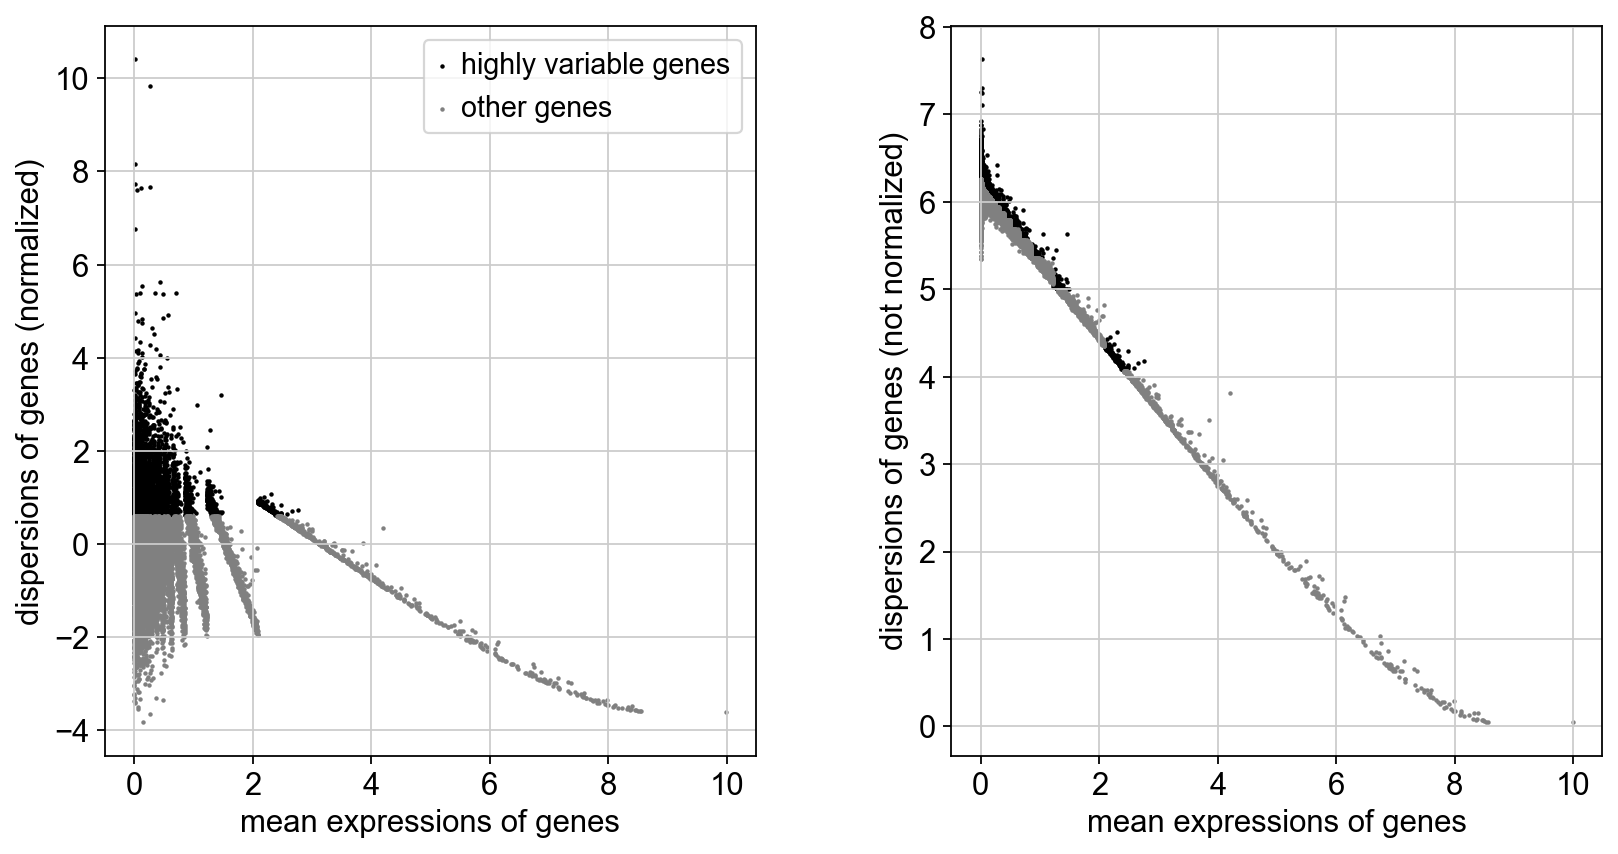

In [12]:
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the adata.var['highly_variable'] field. The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.raw
- highly variable gene annotations in adata.var['highly_variable']

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

## 2.5 Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.


In [13]:
# Calculate the visualizations

sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:32)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


C:\ProgramData\Anaconda3\envs\retisepi\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical
C:\ProgramData\Anaconda3\envs\retisepi\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'oCellType' as categorical
C:\ProgramData\Anaconda3\envs\retisepi\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future versi

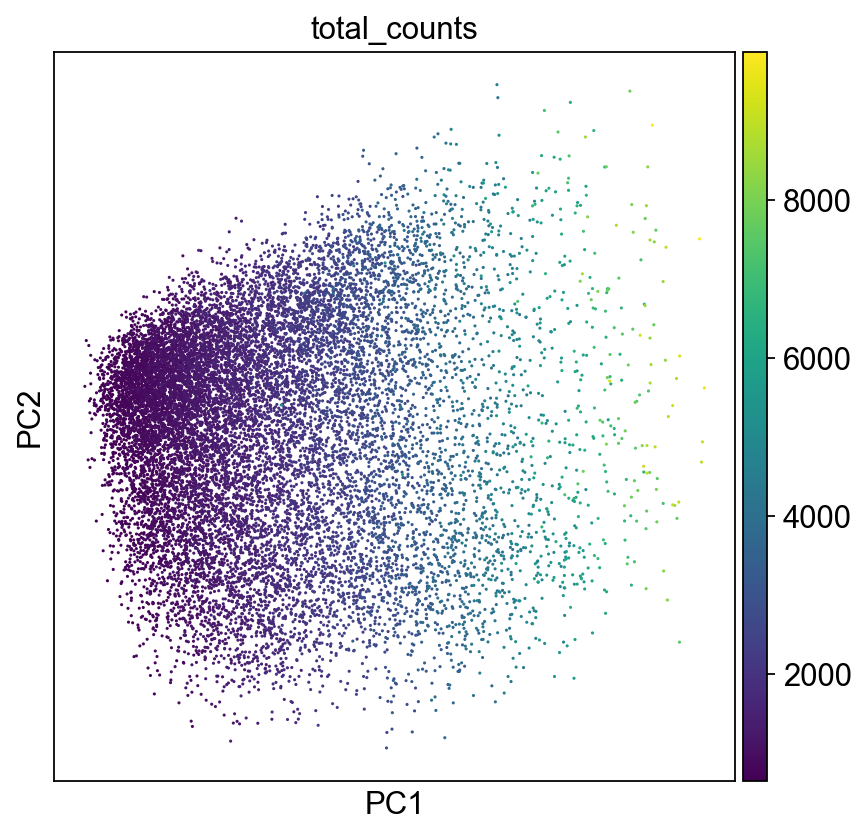

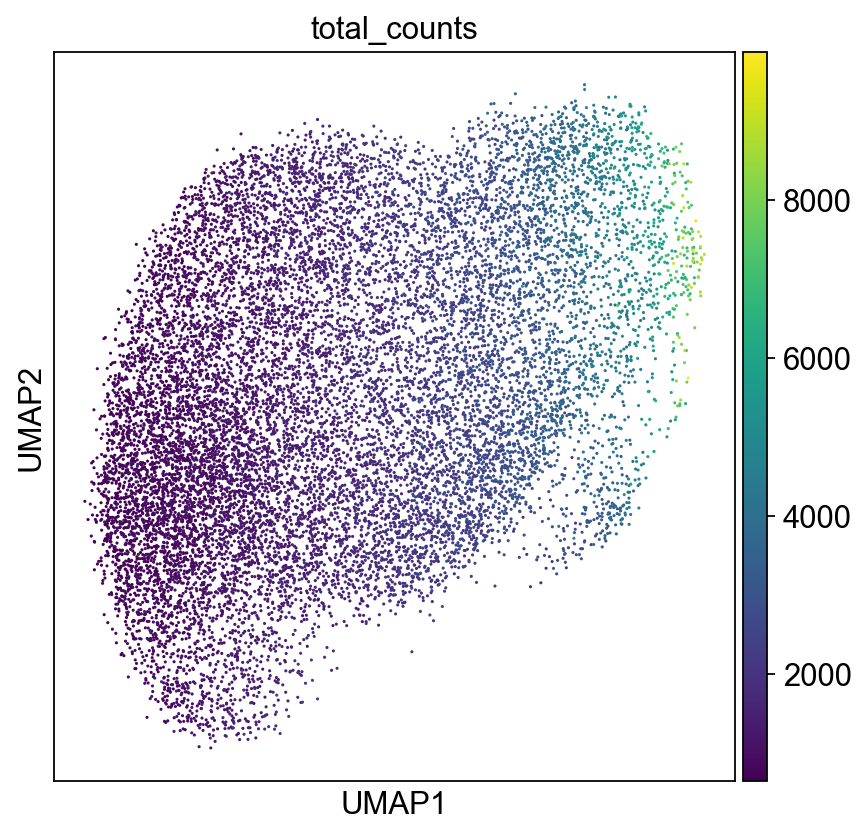

In [14]:

sc.pl.pca_scatter(adata, color='total_counts')
sc.pl.umap(adata, color='total_counts')


# 3 Downstream analysis

<a id="Clustering"></a>

## 3.1 Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this analysis as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph.

In [15]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0_5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain_r0_5', the cluster labels (adata.obs, categorical) (0:00:01)


In [16]:
adata.obs['louvain_r0_5'].value_counts()

0    7432
1    3349
2    2929
3    1464
Name: louvain_r0_5, dtype: int64

In [17]:
adata.obs['louvain_r1'].value_counts()

0    5173
1    2327
2    1874
3    1870
4    1777
5    1525
6     628
Name: louvain_r1, dtype: int64

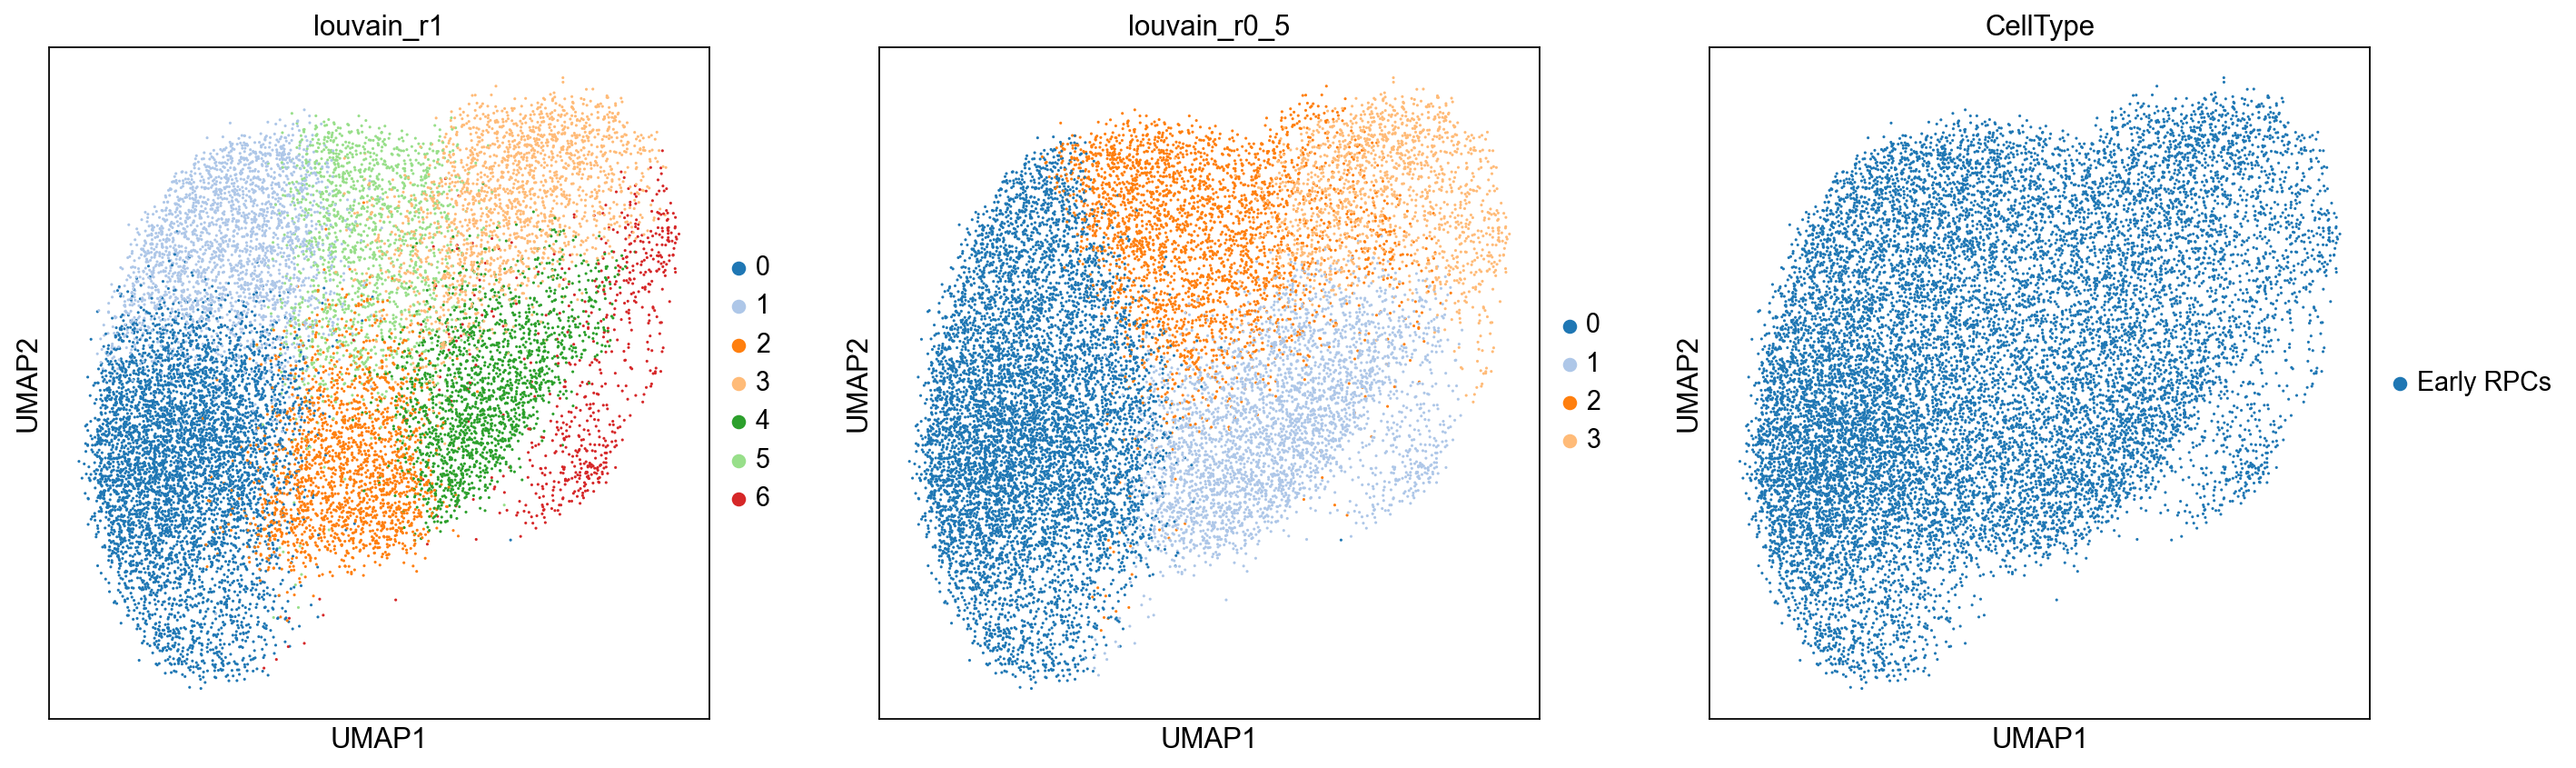

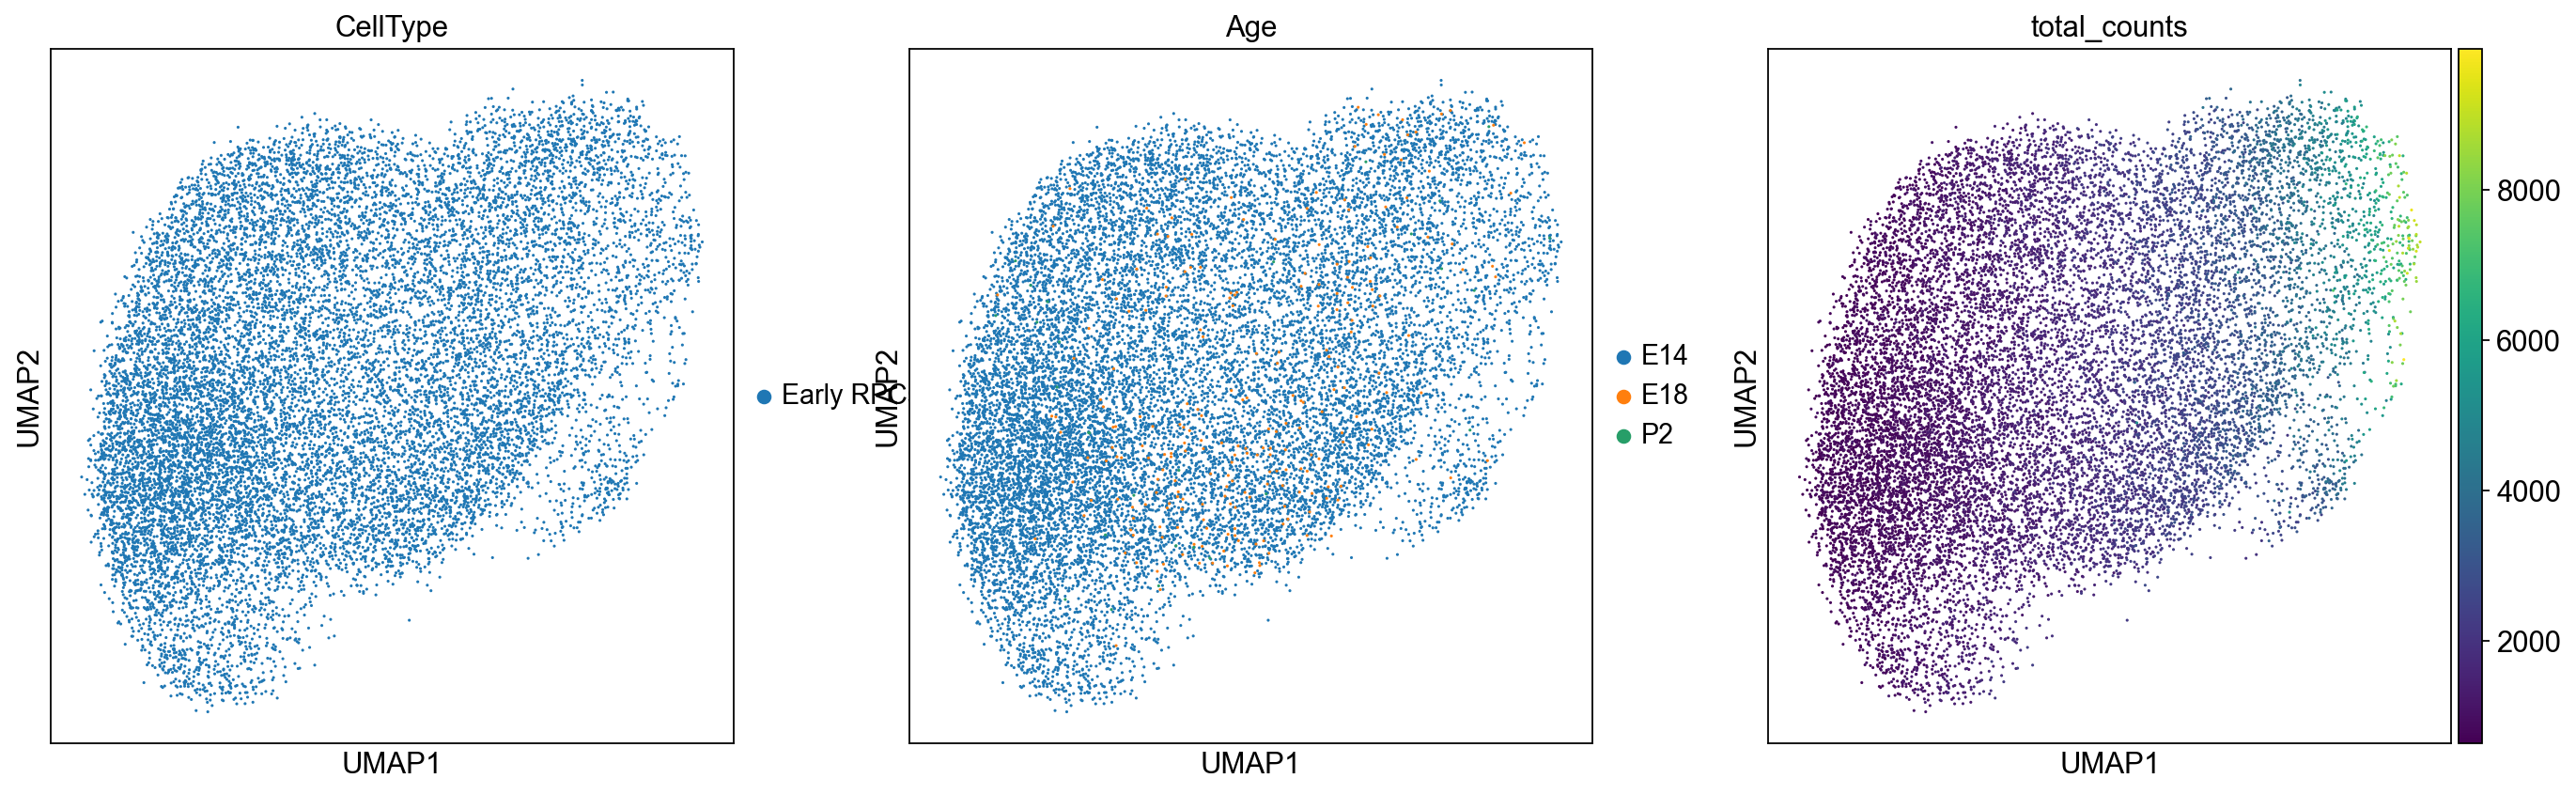

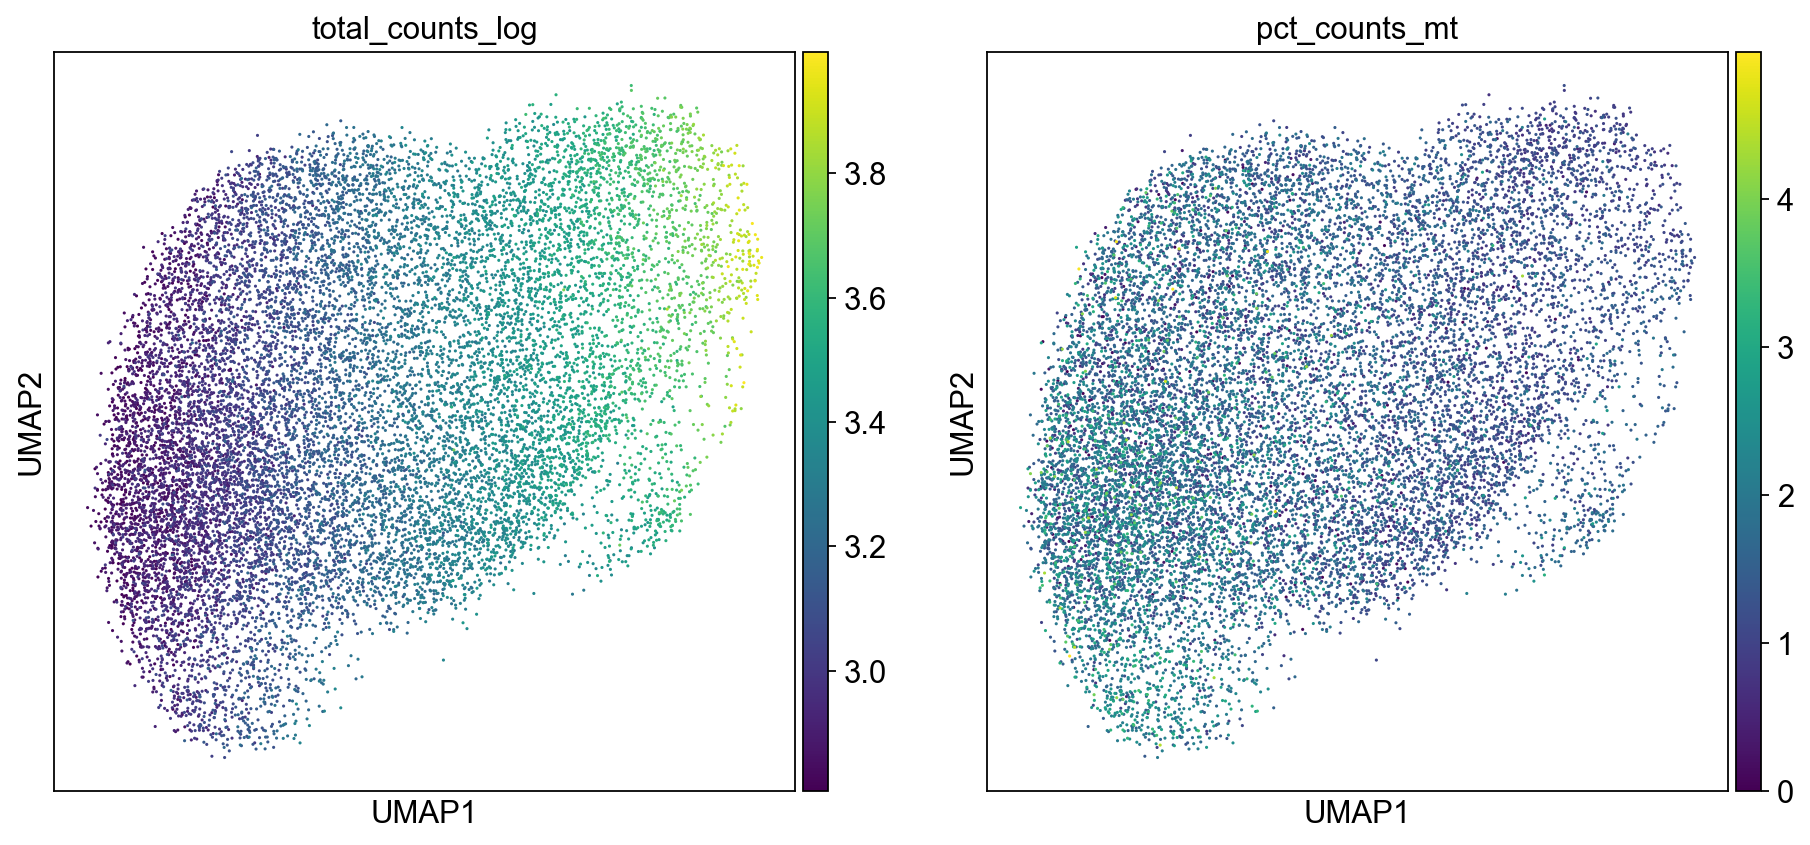

In [18]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0_5','CellType'], palette=sc.pl.palettes.vega_20)
sc.pl.umap(adata, color=['CellType', 'Age', 'total_counts'])
sc.pl.umap(adata, color=['total_counts_log', 'pct_counts_mt'])

## 3.2 Marker genes & cluster annotation

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a Welch t-test . This is the default in scanpy. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.


In [19]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r1', key_added='rank_genes_r1')

ranking genes
    finished: added to `.uns['rank_genes_r1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


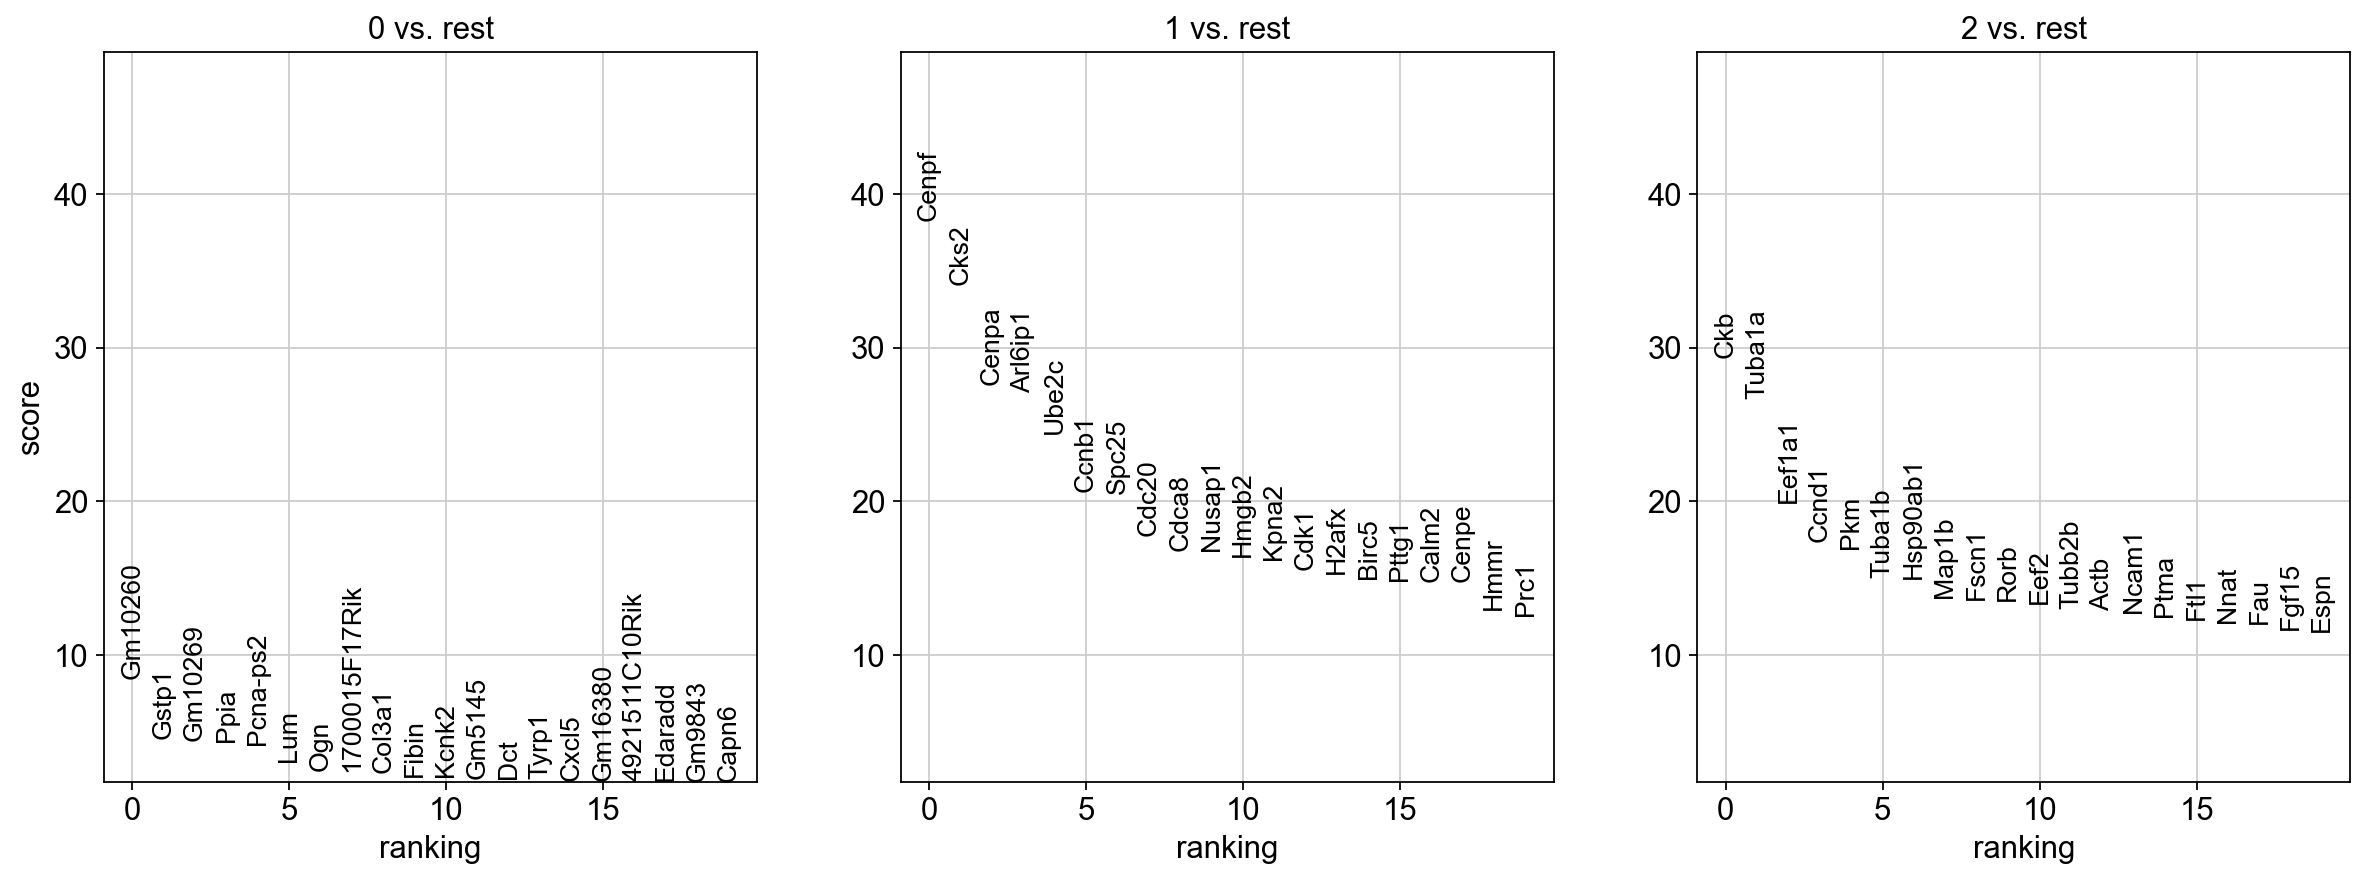

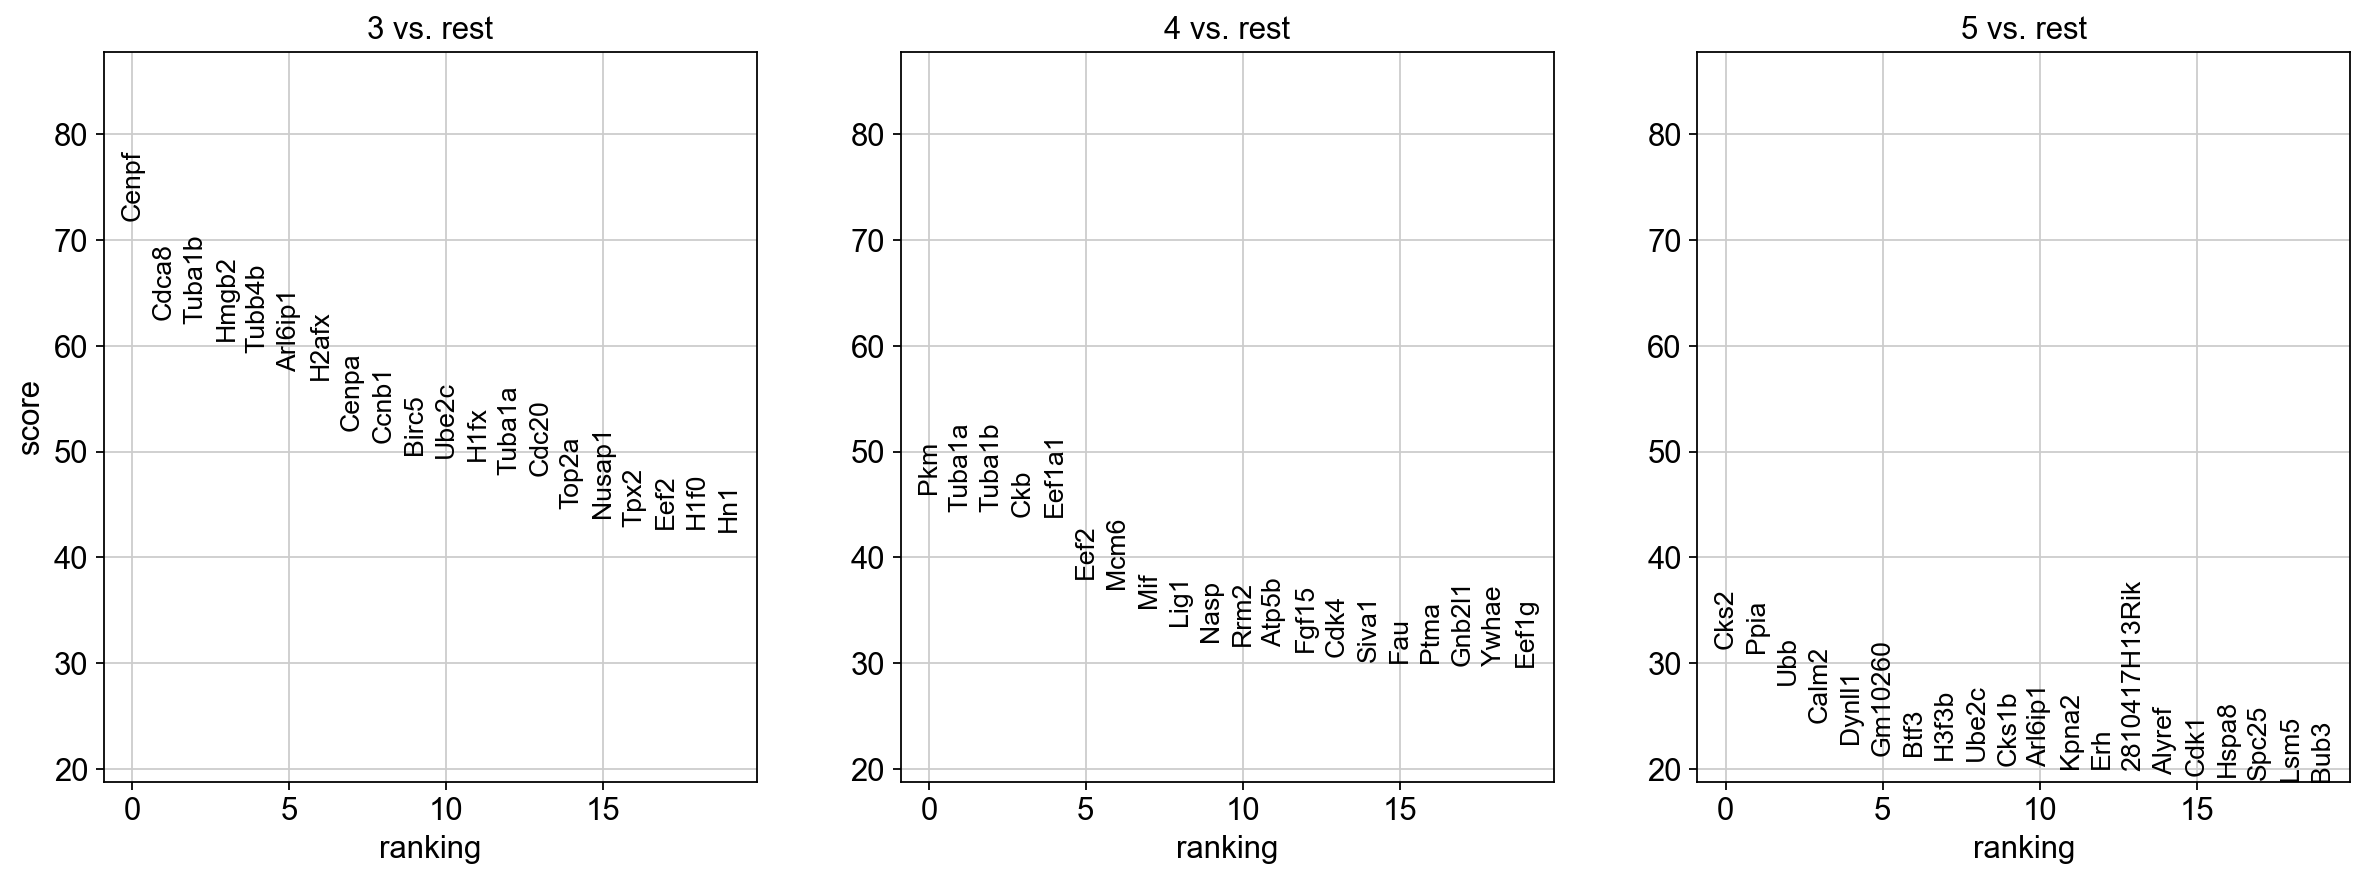

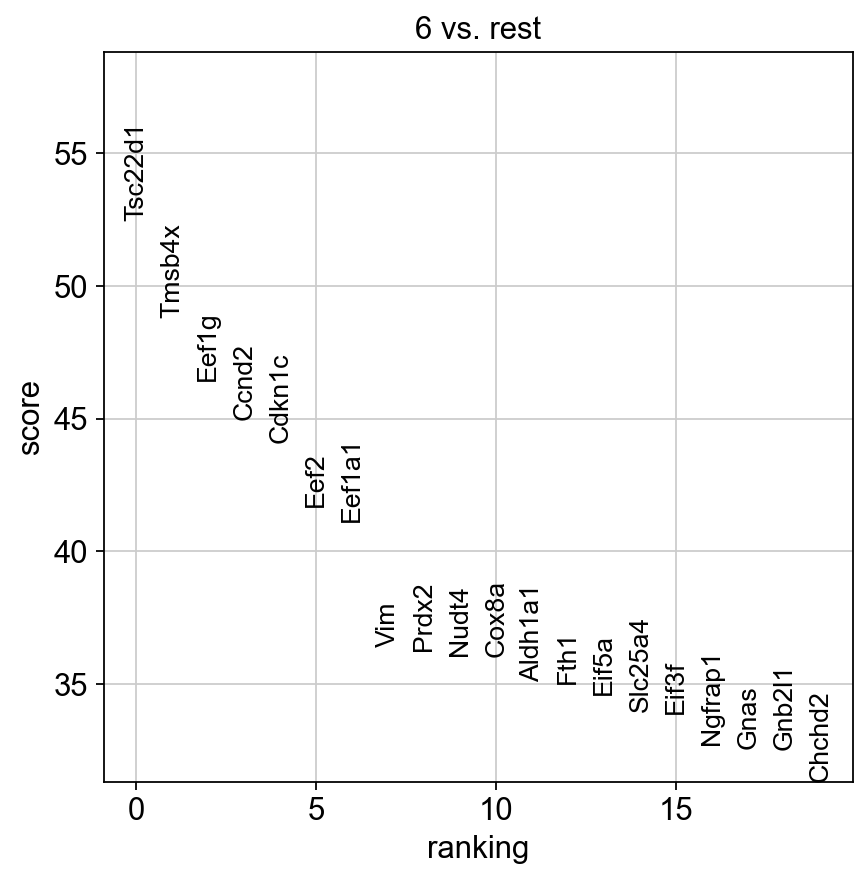

In [20]:
groupsp=adata.obs['louvain_r1'].cat.categories
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=groupsp[:3], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=groupsp[3:6], fontsize=12)
sc.pl.rank_genes_groups(adata, key='rank_genes_r1', groups=groupsp[6:], fontsize=12)


In [21]:
pd.DataFrame(adata.uns['rank_genes_r1']['names']).head(10)

0        1         2        3       4        5        6
0        Gm10260    Cenpf       Ckb    Cenpf     Pkm     Cks2  Tsc22d1
1          Gstp1     Cks2    Tuba1a    Cdca8  Tuba1a     Ppia   Tmsb4x
2        Gm10269    Cenpa    Eef1a1   Tuba1b  Tuba1b      Ubb    Eef1g
3           Ppia  Arl6ip1     Ccnd1    Hmgb2     Ckb    Calm2    Ccnd2
4       Pcna-ps2    Ube2c       Pkm   Tubb4b  Eef1a1   Dynll1   Cdkn1c
5            Lum    Ccnb1    Tuba1b  Arl6ip1    Eef2  Gm10260     Eef2
6            Ogn    Spc25  Hsp90ab1    H2afx    Mcm6     Btf3   Eef1a1
7  1700015F17Rik    Cdc20     Map1b    Cenpa     Mif    H3f3b      Vim
8         Col3a1    Cdca8     Fscn1    Ccnb1    Lig1    Ube2c    Prdx2
9          Fibin   Nusap1      Rorb    Birc5    Nasp    Cks1b    Nudt4

In [22]:

ERPC_clusts = adata.obs['louvain_r1'].cat.categories 
with open('geneBasis_Ube2c.npy', 'rb') as f:
    geneBasis_genes = np.load(f)
geneDE_genes=[]
for clust in ERPC_clusts:
    gene_names_ls=np.array(adata.uns['rank_genes_r1']['names'][clust])
    geneDE_genes=np.concatenate((geneDE_genes,gene_names_ls[:50]),axis=0)
    print('list of common genes in %s with geneBasis is %s :' % (clust, np.intersect1d(gene_names_ls[:50],geneBasis_genes)))



list of common genes in 0 with geneBasis is [] :
list of common genes in 1 with geneBasis is ['Bub3' 'Cenpa' 'Cenpf' 'Ube2c'] :
list of common genes in 2 with geneBasis is ['Epha5' 'Hes5' 'Hmgcs1'] :
list of common genes in 3 with geneBasis is ['Bub3' 'Cenpa' 'Cenpf' 'Ube2c'] :
list of common genes in 4 with geneBasis is ['Rrm2'] :
list of common genes in 5 with geneBasis is ['Bub3' 'Cenpa' 'Cenpf' 'Erh' 'Lsm5' 'Lsm8' 'Ube2c'] :
list of common genes in 6 with geneBasis is ['Aldh1a1' 'Nudt4'] :


# 4 Summary

In this report, we performed single cell rna data analysis on  on Early RPC cells and compared the resulted marker genes with the ones obtained geneBasis scheme. 
